In [7]:
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

In [8]:
def readMODELnc(filename, var):
    """ 
    Read a variable from a NEMO output (netcdf 3 or 4)
    """

    f = netcdf.netcdf_file(filename, 'r')
    data = f.variables[var].data
    f.close()

    return data



## Extract the thermocline depth (depth of the 13C isotherm) for the 4 Celtic sea moorings ##

In [9]:
list_mooring = ['ST1','ST2','ST4','ST5']

depth_thermocline_mod = np.zeros((790,4))
depth_thermocline_obs =  np.zeros((790,4))
print(depth_thermocline_mod.shape)
Tlen = 790

count = 0
for numb in list_mooring:
    print(numb)
    filename = 'Moorings_AMM60/mooring_' + numb +'.nc'
    temp_obs = readMODELnc(filename,'temp_obs')
    temp_mod = readMODELnc(filename,'temp_mod')
    depth = readMODELnc(filename,'depth')
    temp_mod_noNaN = np.zeros((temp_mod.shape[0]-1,temp_mod.shape[1]))
    temp_obs_noNaN = np.zeros((temp_mod.shape[0]-1,temp_mod.shape[1]))
    for ii in range(0,temp_mod.shape[0]):
        x = temp_mod[ii,:]
        mask = np.isfinite(x)
        xi = np.arange(len(x))
        if mask.sum() != 0:
            xfiltered = np.interp(xi, xi[mask], x[mask])
            temp_mod_noNaN[ii,:] = xfiltered
            x = temp_obs[ii,:]
            mask = np.isfinite(x)
            xi = np.arange(len(x))
            xfiltered = np.interp(xi, xi[mask], x[mask])
            temp_obs_noNaN[ii,:] = xfiltered

    depth_thermocline_mod[:,count] = depth[np.argmin(abs(temp_mod_noNaN-13),axis=0)]
    depth_thermocline_obs[:,count] = depth[np.argmin(abs(temp_obs_noNaN-13),axis=0)]
    count += 1



(790, 4)
ST1
ST2
ST4
ST5


## FFT ##

source https://fr.mathworks.com/matlabcentral/answers/64114-fft-code-on-time-series

( + use of a hanning filter to smooth the data)



In [10]:


Fs = np.divide(1.,3600.) # 1 cycle per hour, so every 3600 sec.
L = Tlen
N = np.ceil(np.log2(L))
f = np.multiply(Fs/np.power(2,N),range(0,int(np.power(2,N-1)-1)))

win_hanning = np.hanning(L)
inv_hanning = np.sqrt(np.sum(np.square(win_hanning[:np.floor(L/2)],win_hanning[:np.floor(L/2)])))

fftamm60 = np.zeros((511,4))
fftobsamm60 = np.zeros((511,4))
for xx in range(0,4):
    mod_norm = np.divide(np.multiply(win_hanning,depth_thermocline_mod[:,xx]),inv_hanning)
    obs_norm = np.divide(np.multiply(win_hanning,depth_thermocline_obs[:,xx]),inv_hanning)
    FFTmod = np.fft.fft(mod_norm,int(np.power(2,N)))
    fft_real_mod_amm60 = np.multiply(FFTmod,np.conj(FFTmod))

    FFTobs = np.fft.fft(obs_norm,int(np.power(2,N)))
    fft_real_obs_amm60 = np.multiply(FFTobs,np.conj(FFTobs))
    famm60 = f
    fftamm60[:,xx] = fft_real_mod_amm60[0:int(np.power(2,N-1)-1)]
    fftobsamm60[:,xx] = fft_real_obs_amm60[0:int(np.power(2,N-1)-1)]



/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/jeff/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


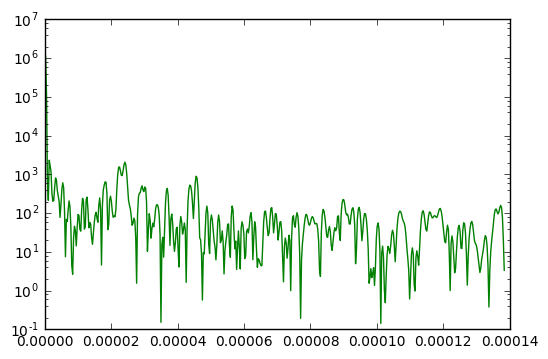

In [11]:
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
%matplotlib inline
plt.semilogy(famm60,fftobsamm60[:,0],color='k')
plt.hold()
plt.semilogy(famm60,fftobsamm60[:,1],color='b')
plt.semilogy(famm60,fftobsamm60[:,2],color='r')
plt.semilogy(famm60,fftobsamm60[:,3],color='g')



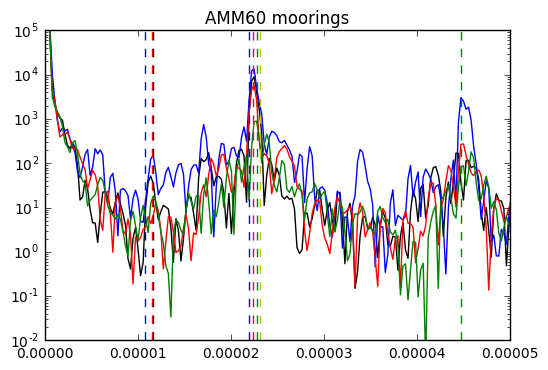

In [20]:
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
%matplotlib inline
plt.semilogy(famm60,fftamm60[:,0],color='k')
plt.hold()
plt.semilogy(famm60,fftamm60[:,1],color='b')
plt.semilogy(famm60,fftamm60[:,2],color='r')
plt.semilogy(famm60,fftamm60[:,3],color='g')


period_hrs = 12.42; lineformat = 'r--'; label='M2'
plt.semilogy( [1/(3600*period_hrs), 1/(3600*period_hrs)], [1E-2, 1E7], lineformat)
#ax.text(1/(3600*period_hrs), 1E6, label)

period_hrs = 12.00; lineformat = 'y--'; label='S2'
plt.semilogy( [1/(3600*period_hrs), 1/(3600*period_hrs)], [1E-2, 1E7], lineformat)

period_hrs = 25.82; lineformat = 'b--'; label='O1'
plt.semilogy( [1/(3600*period_hrs), 1/(3600*period_hrs)], [1E-2, 1E7], lineformat)

period_hrs = 23.93; lineformat = 'k--'; label='K1'
plt.semilogy( [1/(3600*period_hrs), 1/(3600*period_hrs)], [1E-2, 1E7], lineformat)

period_hrs = 12.66; lineformat = 'b--'; label='N2'
plt.semilogy( [1/(3600*period_hrs), 1/(3600*period_hrs)], [1E-2, 1E7], lineformat)

period_hrs = 24.07; lineformat = 'r--'; label='P1'
plt.semilogy( [1/(3600*period_hrs), 1/(3600*period_hrs)], [1E-2, 1E7], lineformat)

period_hrs = 12.19; lineformat = 'g--'; label='L2'
plt.semilogy( [1/(3600*period_hrs), 1/(3600*period_hrs)], [1E-2, 1E7], lineformat)

period_hrs = 6.21; lineformat = 'g--'; label='M4'
plt.semilogy( [1/(3600*period_hrs), 1/(3600*period_hrs)], [1E-2, 1E7], lineformat)

plt.xlim([0,5E-5])
plt.ylim([1E-2, 1E5])
plt.title('AMM60 moorings')


plt.savefig('AMM60_fft_moorings.png')

